# Tutorial 3: Applying Dynamic Forcing Functions to GRN Nodes in Continuous Models
When working with NFSMs, the signals applied to the "input nodes" of the GRN are typically 
not changing until the system reaches an equilibrium. Here we show how to use Cellnition to 
run a temporal simulation where an input node is stimulated by a sinusoidal signal, and how to visualize the output.  

In this tutorial, we create a continuous, differential-equation based model of the larger MAPK network and 
show how to run the time simulation on this larger model case. 

In [1]:
import os
import csv
import copy
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib import colors
from matplotlib import colormaps
from matplotlib.patches import Circle

from scipy.sparse import lil_array

from cellnition.science.network_models.network_enums import (EdgeType, 
                                                             GraphType, 
                                                             NodeType, 
                                                             InterFuncType, 
                                                             CouplingType, 
                                                             EquilibriumType
                                                            )
from cellnition.science.network_models.probability_networks import ProbabilityNet
from cellnition.science.networks_toolbox.netplot import plot_network

from cellnition.science.network_models.network_library import (
                                                StemCellTriadChain,
                                                StemCellTriadChain0,
                                                AKTNet,
                                                hESC_9a,
                                                MAPK_net
                                                )
from cellnition.science.networks_toolbox.state_machine import StateMachine

In [2]:
# Define your desired root save path for output images, graphs, and text files:
save_path_base = '/home/pietakio/Dropbox/Levin_2024/CellnitionFinale/' # Root directory
save_path_oo = os.path.join(save_path_base, 'April24_2025') # Sub-root directory
if not os.path.isdir(save_path_oo): # Create the sub-root directory 
    os.makedirs(save_path_oo)

In [3]:
# Load the base information from the Cellnition library:
# libg = StemCellTriadChain()
# libg = hESC_9a() # Larger OCT4-NANOG-SOX2 core network with additional factors 
libg = MAPK_net() # MAPK Cancer Cell Fate Network from Cell Collective database

libg.count_nodes() # We do this just to ensure the node number is correct in the imported network

In [4]:
# Define main study parameters for the analytical model:

# In returning eq'm solutions, we use a fractional-rounding scheme to either classify solutions as "the same"
# or to differentiate them as different solutions. This is controlled by the user-specified node_express_level,
# which determines how many levels are present in the fractional-rounding. For example, if node_express_level
# is 5.0, then the possible values for the node expression are: 0.0, 0.25, 0.5, 0.75, and 1.0; the expression
# levels differ by 25%. The user may specify higher levels of resultion by increasing the number of node
# expression levels (e.g. 11.0 levels gives 0.1 increments and 10% difference between each level); however, at
# some point one must ask what is truly a significant difference in the expression of a gene between different 
# scenarios? We believe a 10% difference is likely to be the highest resolution that would be detectable in 
# experiments. 
node_express_levels = 5.0

# Small value taken for zero:
pmin = 1.0e-6

# Specify the form of the functions determining the node coupling interactions:
# interaction_function_type = InterFuncType.hill # Hill function
interaction_function_type = InterFuncType.logistic # Logisitc function (recommended as it's better behaived in general)

# Specify how to combine multiple nodes interacting together:
multi_coupling_type = CouplingType.mix1 # Mix1 combines multiple activators in an "OR" fashion (additive) inhibitors in an "AND" fashion (multiplicative). 
# multi_coupling_type = CouplingType.additive # All types of interactions combine in an additive "AND" fashion. 
# multi_coupling_type = CouplingType.multiplicative # All types of interactions combine in a multiplicative "OR" fashion. 

# NOTE: Mix1 is the default combinatory strategy. CouplingType.mix1 combines multiple activators in an "OR" fashion (additive) and 
# multiple inhibitors in an "AND" fashion (multiplicative). This combinatory strategy specifies that individual activators have 
# equal influence on the downstream gene activation, whereas all inhibitors must be absent for gene activaton and the pressense of
# a single inhibitor can cease all downstream gene expression of the downstream node. Furthermore, in the continuous model, mix1 combines 
# the set of all activators and the set of all inhibitors in a multiplicative "AND" fashion, which states: the effect of activators must
# be present AND all inhibitors must be absent for gene expression at the node. CouplingType.mix1 has the exception that if a node only has
# inhibitors acting on it, it is assumed to have constitutive expression, such that only the absense of the inhibitors is required for 
# expression. This convention of mix1 is used as the standard heuristic in Boolean network models (see Schwab et al. - 2020).

# Set simulation parameters for the network:
# parameter specifying the rate for individual node expression reactions.
# The larger the dd value, the faster the overall rate of the expression reaction. Also, this 
# rate parameter's value is independent of whether Hill or Logistic base functions are used. 
# Here the parameter is applied uniformly to all node-temporal update equations, however,
# by defining a list of parameters (one for each node), heterogenous parameters are specified. 
d_base = 1.0 

# automatically assign the parameters for the study:
if interaction_function_type is InterFuncType.logistic:
    n_base = 15.0 # standard is 15.0, slope/steepness/nonlinearity of interaction function
    b_base = 0.5 # standard is 0.5, centre of interaction function 

else:
    n_base = 3.0 # standard is 3.0, slope/steepness/nonlinearity of interaction Hill function
    b_base = 2.0 # standard is 2.0, reciprocal centre of interaction Hill function  

In [5]:

# Use the above-specified options to define a final sub-directory for the results:
save_path_o = os.path.join(save_path_oo, f'_{interaction_function_type.name[0:4]}_{multi_coupling_type.name[0:4]}')
if not os.path.isdir(save_path_o):
    os.makedirs(save_path_o)

# Final save directory is for the individual network that is being studied: 
save_path = os.path.join(save_path_o, f'{libg.name}' )
if not os.path.isdir(save_path):
    os.makedirs(save_path)

# Set some easily-modifiable text parameters for plots: 
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fimg = '.png' # Format for exported graph images. Can use '.png' for bitmap or '.svg' fo

In [6]:
# Generate and characterize the network from the specifications in MAPK_net:
pnet = ProbabilityNet(libg.N_nodes, 
                      interaction_function_type=interaction_function_type,
                      node_expression_levels = node_express_levels)

pnet.build_network_from_edges(libg.edges) # build the network
pnet.characterize_graph()  # characterize the graph (this is needed to set internal parameters for the NFSM creation)
pnet.set_node_types()  # set the node types
pnet.set_edge_types(libg.edge_types)  # set the edge types to the network

In [7]:
# save plots of the GRN graph:
# Shared parameters used on the following graph images:
arrowsize = 2.0 # Size of the directed head of the graph edges (relative units) 
node_font_size = 24 # Size of the font used on node labels
net_font_name =  'DejaVu Sans Bold' # name of font used on node labels
edge_width = 2.0 # with of interaction edges
nde_outline = 'Black' # colour of the node outline (if no outline is desired use "None")
rev_font_color = False # Reverse the color of node text? It is black by default. 
label_edges=True # Label the edges with their index in the ProbabilityNet, pnet? 

# NOTE: label_edges=True is useful in inspection and validation of equations, as the 
# edge index is also the index of 'n_base' and 'bb' params, above (the 'dd' param is labeled to node index). 

# The network shown in a hierarchical layout with node color representing the "hierarchical level" of the node
# as calculated in 'characterize_graph' and described in Moutsinas et. al - 2021: 
graph_net_hier = f'hier_graph_{libg.name}{fimg}' 
save_graph_net_hier = os.path.join(save_path, graph_net_hier)

gp=plot_network(pnet.nodes_list,
                pnet.edges_list,
                pnet.node_types,
                pnet.edge_types,
                node_vals = pnet.hier_node_level, # color the nodes to their hierarchical level
                val_cmap = 'viridis_r',
                save_path=save_graph_net_hier,
                layout='dot',
                rev_font_color=rev_font_color,
                label_edges=label_edges,
                net_font_name=net_font_name,
                node_font_size=node_font_size,
                edge_width=edge_width,
                nde_outline=nde_outline,
                arrowsize=arrowsize
                )

# The network shown in a circular layout with nodes colored acording to whether they are present in cycles or not:
graph_net_circ = f'circ_graph_{libg.name}{fimg}'
save_graph_net_circo = os.path.join(save_path, graph_net_circ)   

cycle_tags = np.zeros(pnet.N_nodes)
cycle_tags[pnet.nodes_in_cycles] = 1.0

gp=plot_network(pnet.nodes_list,
                pnet.edges_list,
                pnet.node_types,
                pnet.edge_types,
                node_vals = cycle_tags,
                val_cmap = 'Blues',
                save_path=save_graph_net_circo,
                layout='circo',
                rev_font_color=rev_font_color,
                label_edges=label_edges,
                net_font_name=net_font_name,
                node_font_size=node_font_size,
                edge_width=edge_width,
                nde_outline=nde_outline,
                arrowsize=arrowsize
                )

In [8]:
# Create the continuous differential-equation based model as both a set of symbolic math equations (in the Sympy API) and
# as numerical functions:
# Note that if running a larger network like the MAPKNet, it can take some time to build the analytical model 
# (the MAPKNet takes about 1 minute to build on my machine). 
# Get the adjacency matrices for this model:
A_add_s, A_mul_s, A_full_s = pnet.build_adjacency_from_edge_type_list(libg.edge_types,
                                                                      pnet.edges_index,
                                                                      coupling_type=multi_coupling_type)

# Build the analytical model consisting of sympy equations and numerical (numpy-based) computational forms:
pnet.build_analytical_model(A_add_s, A_mul_s)

In [9]:
# Visually inspect the form of model equations here in Jupyter (NOTE: for the MAPK_net these are quite large and unweildy!). 
# Equations specifying the rate of change of each node in c_vect_s_viz as a function of time:
pnet.dcdt_vect_s_viz # uncomment this line to visually inspect the equations

Matrix([
[                                                                                                                                               -AKT*d_0 + d_0/((1 + exp(-n_0*(PDK1 - beta_0)))*(exp(n_1*(PTEN - beta_1)) + 1))],
[                                                                                      -AP1*d_1 + d_1*(1/(3*(1 + exp(-n_4*(JUN - beta_4)))) + 1/(3*(1 + exp(-n_3*(FOS - beta_3/4)))) + 1/(3*(1 + exp(-n_2*(ATF2 - beta_2/2)))))],
[                                                                                                                          -ATF2*d_2 + d_2*(1/(2*(1 + exp(-n_9*(JNK - beta_9/4)))) + 1/(2*(1 + exp(-n_10*(-beta_10/4 + p38)))))],
[                                                                                                                                                                        -ATM*d_3 + d_3/(1 + exp(-n_11*(DNA_damage - beta_11)))],
[                                                      -Apoptosis*d_4 + d_4*(1/(2*(1 + 

In [10]:
# Save the model equations in an image format (NOTE: these are very large for the MAPK_net model):
eqn_img = f'Eqn_{libg.name}.png'
save_eqn_image = os.path.join(save_path, eqn_img)

pnet.save_model_equations(save_eqn_image,  
                          substitute_node_labels=True)

In [11]:
dt = 1.0e-3 # This is the time step that the simulation runs on for explicit euler
dt_samp = 0.15 # This is the time step that the simulation is sampled on

tend = 150.0 # Time at which the simulation should end (units depend on parameter units)

# Get the full time vector (tvect) and the sampled time vector (tvectr)
tvect, tvectr = pnet.make_time_vects(tend, dt, dt_samp)

# this is a starting state for expression levels of nodes in the network:
cvecti = np.zeros(pnet.N_nodes) + pnet.p_min 

# Creating a dynamic stimulation to be applied to the GRN's input nodes:
sig_inds = pnet.input_node_inds # These are the nodes that are to be stimulated
N_sigs = len(sig_inds) # The length of nodes that will be stimulated

# Set a baseline value for the minima of any of the stimulation node levels. Note that concentrations
# cannot go below zero. Here we set the minima to 0.0:
sig_base_vals = [0.0 for i in pnet.input_node_inds] 

# Create the stimulation signals, lets use a sinusoidal function on the first input node index:
freq = 1.0/30.0 # let's have the cycle repeat every 30 time units
stim_i = 1 # index of the input node that we'll apply the sinusoid to (note this is not the 
# absolute node index in the GRN but the index wrt pnet.input_node_inds array). 
sine_stim = (1/2)*(np.sin(2*np.pi*freq*tvect) + 1.0) # note we need this to be at all time steps

# Initialize a numpy array with all zeros in it; it needs to be the size of all nodes in the GRN:
stim_sigs = lil_array(np.zeros((len(tvect), pnet.N_nodes))) # create a sparse array to reduce memory requirements
stim_sigs[:, pnet.input_node_inds[stim_i]] = sine_stim 

# Calculate the output of the GRN under this dynamic sinusoidal stimulation:
ctime = pnet.run_time_sim(tvect, # main time vector
                          tvectr, # sampled time vector
                          cvecti, # initial state of the network nodes
                          sig_inds=sig_inds, # indices of the input inds (must be pnet.input_node_inds)
                          sig_vals=stim_sigs, # the ndarray with the stimulation signal in it
                          constrained_inds=None, # other node inds to constrain that are not input node inds
                          constrained_vals=None, # monotonic values of other node inds to constrain 
                          d_base=d_base, # d_base parameter (defined above)
                          n_base=n_base, # n_base parameter (defined above)
                          beta_base=b_base # b_base parameter (defined above)
                         )

# The ctime array has the time-sampled expression level of all nodes in the network as a function 
# of sampled time step, which is specfied in tvectr. 

In [12]:
pnet.nodes_list

['AKT',
 'AP1',
 'ATF2',
 'ATM',
 'Apoptosis',
 'BCL2',
 'CREB',
 'DNA_damage',
 'DUSP1',
 'EGFR',
 'EGFR_stimulus',
 'ELK1',
 'ERK',
 'FGFR3',
 'FGFR3_stimulus',
 'FOS',
 'FOXO3',
 'FRS2',
 'GAB1',
 'GADD45',
 'GRB2',
 'Growth_Arrest',
 'JNK',
 'JUN',
 'MAP3K1_3',
 'MAX',
 'MDM2',
 'MEK1_2',
 'MSK',
 'MTK1',
 'MYC',
 'PDK1',
 'PI3K',
 'PKC',
 'PLCG',
 'PPP2CA',
 'PTEN',
 'Proliferation',
 'RAF',
 'RAS',
 'RSK',
 'SMAD',
 'SOS',
 'SPRY',
 'TAK1',
 'TAOK',
 'TGFBR',
 'TGFBR_stimulus',
 'p14',
 'p21',
 'p38',
 'p53',
 'p70']

In [14]:
pnet.output_node_inds # Indices of the output nodes -- we'll plot output on these

[4, 21, 37]

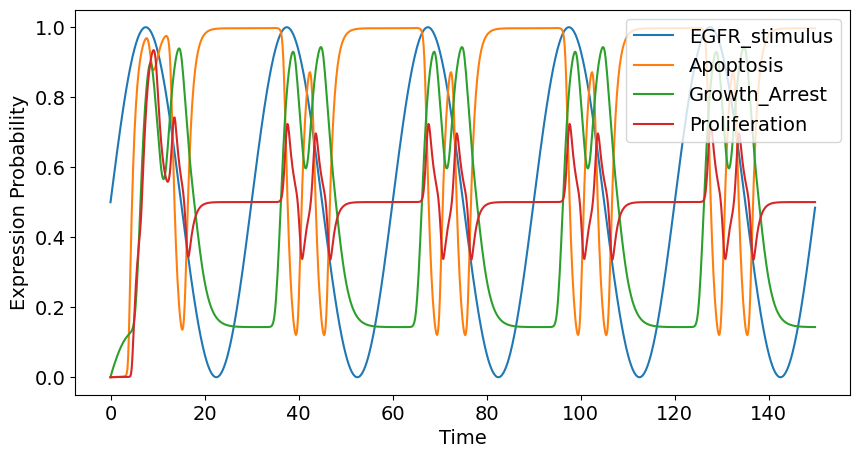

In [30]:
# Plot things up to see what we have -- here picking output nodes to plot: 
plt.figure(figsize=(10,5))
plt.plot(tvectr, ctime[:, sig_inds[stim_i]], label=pnet.nodes_list[sig_inds[stim_i]]) # Stimulated node (EGFR)
plt.plot(tvectr, ctime[:, 0], label=pnet.nodes_list[4]) # Apoptosis
plt.plot(tvectr, ctime[:, 1], label=pnet.nodes_list[21]) # Growth Arrest
plt.plot(tvectr, ctime[:, 5], label=pnet.nodes_list[37]) # Proliferation
plt.xlabel("Time")
plt.ylabel("Expression Probability")

plt.legend(frameon=True, loc='upper right')
plt.show()